In [ ]:
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
unlabeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
unlabeled_datagen = unlabeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/MelanomaDetection",
                                                           target_size=(32,32),classes=['unlabeled'],batch_size=256)

Found 7018 images belonging to 1 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Input,Conv2D,LeakyReLU,Flatten,Dropout,Dense,Reshape,Conv2DTranspose,BatchNormalization
import tensorflow as tf

In [ ]:
def discriminator():

  dis = Sequential(name="Discriminator")

  dis.add(Conv2D(filters=64,kernel_size=4,strides=2,padding="same",input_shape=(32,32,3),use_bias=False))
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=256,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Flatten())
  dis.add(Dropout(0.4))

  dis.add(Dense(units=1,activation="sigmoid"))

  return dis

In [ ]:
def generator():

  noise_shape = 100
  gen = Sequential(name="Generator")

  gen.add(Input(shape=(noise_shape,)))
  gen.add(Dense(units=4*4*100))
  gen.add(Reshape((4,4,100)))

  gen.add(Conv2DTranspose(filters=256,kernel_size=4,strides=1,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=3,kernel_size=4,strides=2,padding="same",activation="tanh",use_bias=False))

  return gen

In [ ]:
D = discriminator()

In [ ]:
D.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        3072      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         131072    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)       

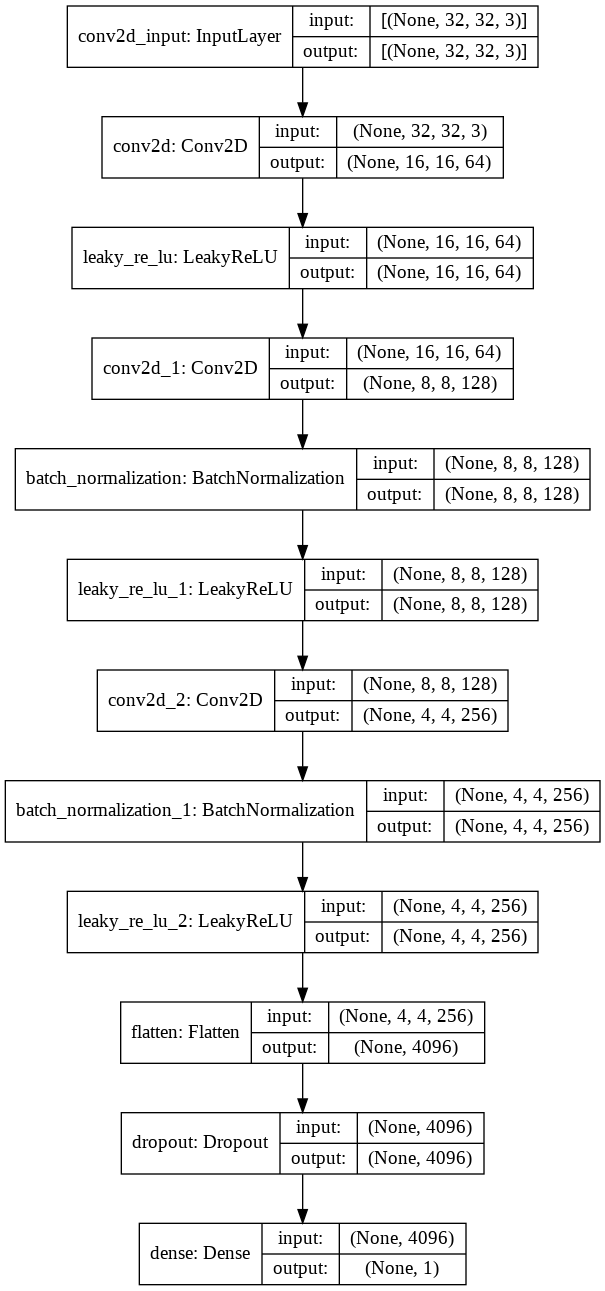

In [ ]:
tf.keras.utils.plot_model(model=D,show_shapes=True)

In [ ]:
G = generator()

In [ ]:
G.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1600)              161600    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 100)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         409600    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         51

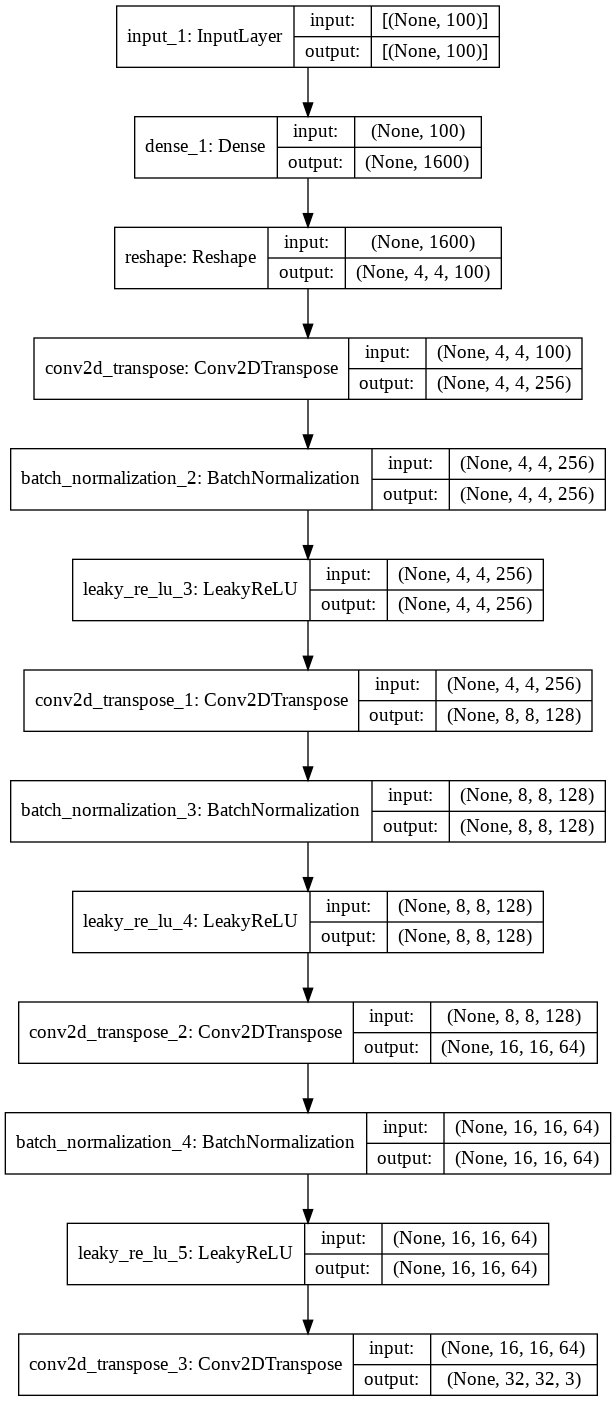

In [ ]:
tf.keras.utils.plot_model(model=G,show_shapes=True)

In [ ]:
random_noise = tf.random.normal(shape=(1,100))

In [ ]:
generated_image = G(random_noise,training=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


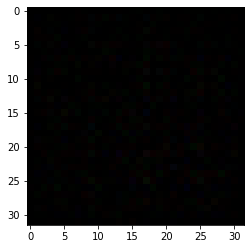

In [ ]:
plt.imshow(generated_image[0,:,:,:])

In [ ]:
posterior = D(generated_image)

In [ ]:
print(posterior)

tf.Tensor([[0.5000404]], shape=(1, 1), dtype=float32)


In [ ]:
GAN_epochs = 50
noise_shape = 100
batch_size = 256

In [ ]:
import keras
from IPython import display
import numpy as np

In [ ]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def D_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(real_imgs_preds)) + tf.ones_like(real_imgs_preds)
  fake_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(fake_imgs_preds)) + tf.zeros_like(fake_imgs_preds)

  real_imgs_bce_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_bce_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_bce_loss + fake_imgs_bce_loss

  return total_loss

In [ ]:
def G_loss(fake_imgs_preds):

  fake_imgs_labels = tf.ones_like(fake_imgs_preds)

  return bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

In [ ]:
D_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0008,beta_1=0.3)
G_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0004,beta_1=0.1)

In [ ]:
GAN_checkpoint_dir = "/content/drive/MyDrive/GAN_training_checkpoints"
GAN_checkpoint_prefix = os.path.join(GAN_checkpoint_dir,"ckpt")
GAN_checkpoint = tf.train.Checkpoint(optimizer=[D_optimizer,G_optimizer],model=[D,G])

In [ ]:
@tf.function
def training_step(real_imgs_mini_batch):

  G.trainable = False
  noise = tf.random.normal(shape=(batch_size,noise_shape))
  generated_imgs_mini_batch = G(noise,training=False)

  D.trainable = True

  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

    real_imgs_preds = D(real_imgs_mini_batch,training=True)
    fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

    disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
    D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

    D.trainable = False
    G.trainable = True

    noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_imgs_mini_batch = G(noise,training=True)

    fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

    gen_loss = G_loss(fake_imgs_preds)

    gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
    G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

In [ ]:
constant_noise = tf.random.normal(shape=(16,noise_shape))

In [ ]:
def generate_and_save_images(generator_model,epoch,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.savefig("Images_at_Epoch_{:04d}.png".format(epoch))
  plt.show()

In [ ]:
real_imgs_path = "/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/unlabeled"

In [ ]:
def train_gan(real_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for image_batch in real_imgs_datagen:

      print("Training GAN at Time Step {} of Epoch {}".format(time_step,epoch+1))
      training_step(real_imgs_mini_batch=image_batch[0])

      if time_step > len(os.listdir(real_imgs_path))//batch_size:
        break

      time_step = time_step + 1

    generate_and_save_images(generator_model=G,epoch=epoch+1,test_input=constant_noise)

    if (epoch + 1) % 5 == 0:
      GAN_checkpoint.save(file_prefix=GAN_checkpoint_prefix)

  generate_and_save_images(generator_model=G,epoch=total_epochs,test_input=constant_noise)

Training GAN at Time Step 1 of Epoch 1
Training GAN at Time Step 2 of Epoch 1
Training GAN at Time Step 3 of Epoch 1
Training GAN at Time Step 4 of Epoch 1
Training GAN at Time Step 5 of Epoch 1
Training GAN at Time Step 6 of Epoch 1
Training GAN at Time Step 7 of Epoch 1
Training GAN at Time Step 8 of Epoch 1
Training GAN at Time Step 9 of Epoch 1
Training GAN at Time Step 10 of Epoch 1
Training GAN at Time Step 11 of Epoch 1
Training GAN at Time Step 12 of Epoch 1
Training GAN at Time Step 13 of Epoch 1
Training GAN at Time Step 14 of Epoch 1
Training GAN at Time Step 15 of Epoch 1
Training GAN at Time Step 16 of Epoch 1
Training GAN at Time Step 17 of Epoch 1
Training GAN at Time Step 18 of Epoch 1
Training GAN at Time Step 19 of Epoch 1
Training GAN at Time Step 20 of Epoch 1
Training GAN at Time Step 21 of Epoch 1
Training GAN at Time Step 22 of Epoch 1
Training GAN at Time Step 23 of Epoch 1
Training GAN at Time Step 24 of Epoch 1
Training GAN at Time Step 25 of Epoch 1
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

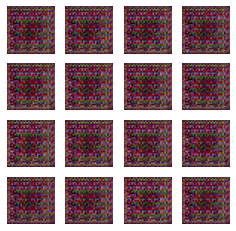

Training GAN at Time Step 1 of Epoch 2
Training GAN at Time Step 2 of Epoch 2
Training GAN at Time Step 3 of Epoch 2
Training GAN at Time Step 4 of Epoch 2
Training GAN at Time Step 5 of Epoch 2
Training GAN at Time Step 6 of Epoch 2
Training GAN at Time Step 7 of Epoch 2
Training GAN at Time Step 8 of Epoch 2
Training GAN at Time Step 9 of Epoch 2
Training GAN at Time Step 10 of Epoch 2
Training GAN at Time Step 11 of Epoch 2
Training GAN at Time Step 12 of Epoch 2
Training GAN at Time Step 13 of Epoch 2
Training GAN at Time Step 14 of Epoch 2
Training GAN at Time Step 15 of Epoch 2
Training GAN at Time Step 16 of Epoch 2
Training GAN at Time Step 17 of Epoch 2
Training GAN at Time Step 18 of Epoch 2
Training GAN at Time Step 19 of Epoch 2
Training GAN at Time Step 20 of Epoch 2
Training GAN at Time Step 21 of Epoch 2
Training GAN at Time Step 22 of Epoch 2
Training GAN at Time Step 23 of Epoch 2
Training GAN at Time Step 24 of Epoch 2
Training GAN at Time Step 25 of Epoch 2
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

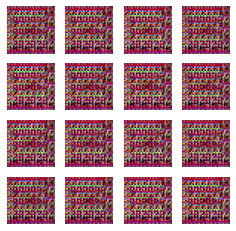

Training GAN at Time Step 1 of Epoch 3
Training GAN at Time Step 2 of Epoch 3
Training GAN at Time Step 3 of Epoch 3
Training GAN at Time Step 4 of Epoch 3
Training GAN at Time Step 5 of Epoch 3
Training GAN at Time Step 6 of Epoch 3
Training GAN at Time Step 7 of Epoch 3
Training GAN at Time Step 8 of Epoch 3
Training GAN at Time Step 9 of Epoch 3
Training GAN at Time Step 10 of Epoch 3
Training GAN at Time Step 11 of Epoch 3
Training GAN at Time Step 12 of Epoch 3
Training GAN at Time Step 13 of Epoch 3
Training GAN at Time Step 14 of Epoch 3
Training GAN at Time Step 15 of Epoch 3
Training GAN at Time Step 16 of Epoch 3
Training GAN at Time Step 17 of Epoch 3
Training GAN at Time Step 18 of Epoch 3
Training GAN at Time Step 19 of Epoch 3
Training GAN at Time Step 20 of Epoch 3
Training GAN at Time Step 21 of Epoch 3
Training GAN at Time Step 22 of Epoch 3
Training GAN at Time Step 23 of Epoch 3
Training GAN at Time Step 24 of Epoch 3
Training GAN at Time Step 25 of Epoch 3
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

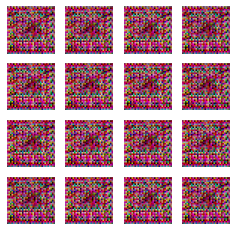

Training GAN at Time Step 1 of Epoch 4
Training GAN at Time Step 2 of Epoch 4
Training GAN at Time Step 3 of Epoch 4
Training GAN at Time Step 4 of Epoch 4
Training GAN at Time Step 5 of Epoch 4
Training GAN at Time Step 6 of Epoch 4
Training GAN at Time Step 7 of Epoch 4
Training GAN at Time Step 8 of Epoch 4
Training GAN at Time Step 9 of Epoch 4
Training GAN at Time Step 10 of Epoch 4
Training GAN at Time Step 11 of Epoch 4
Training GAN at Time Step 12 of Epoch 4
Training GAN at Time Step 13 of Epoch 4
Training GAN at Time Step 14 of Epoch 4
Training GAN at Time Step 15 of Epoch 4
Training GAN at Time Step 16 of Epoch 4
Training GAN at Time Step 17 of Epoch 4
Training GAN at Time Step 18 of Epoch 4
Training GAN at Time Step 19 of Epoch 4
Training GAN at Time Step 20 of Epoch 4
Training GAN at Time Step 21 of Epoch 4
Training GAN at Time Step 22 of Epoch 4
Training GAN at Time Step 23 of Epoch 4
Training GAN at Time Step 24 of Epoch 4
Training GAN at Time Step 25 of Epoch 4
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

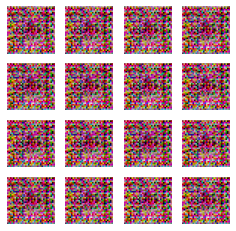

Training GAN at Time Step 1 of Epoch 5
Training GAN at Time Step 2 of Epoch 5
Training GAN at Time Step 3 of Epoch 5
Training GAN at Time Step 4 of Epoch 5
Training GAN at Time Step 5 of Epoch 5
Training GAN at Time Step 6 of Epoch 5
Training GAN at Time Step 7 of Epoch 5
Training GAN at Time Step 8 of Epoch 5
Training GAN at Time Step 9 of Epoch 5
Training GAN at Time Step 10 of Epoch 5
Training GAN at Time Step 11 of Epoch 5
Training GAN at Time Step 12 of Epoch 5
Training GAN at Time Step 13 of Epoch 5
Training GAN at Time Step 14 of Epoch 5
Training GAN at Time Step 15 of Epoch 5
Training GAN at Time Step 16 of Epoch 5
Training GAN at Time Step 17 of Epoch 5
Training GAN at Time Step 18 of Epoch 5
Training GAN at Time Step 19 of Epoch 5
Training GAN at Time Step 20 of Epoch 5
Training GAN at Time Step 21 of Epoch 5
Training GAN at Time Step 22 of Epoch 5
Training GAN at Time Step 23 of Epoch 5
Training GAN at Time Step 24 of Epoch 5
Training GAN at Time Step 25 of Epoch 5
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

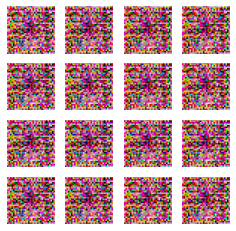

Training GAN at Time Step 1 of Epoch 6
Training GAN at Time Step 2 of Epoch 6
Training GAN at Time Step 3 of Epoch 6
Training GAN at Time Step 4 of Epoch 6
Training GAN at Time Step 5 of Epoch 6
Training GAN at Time Step 6 of Epoch 6
Training GAN at Time Step 7 of Epoch 6
Training GAN at Time Step 8 of Epoch 6
Training GAN at Time Step 9 of Epoch 6
Training GAN at Time Step 10 of Epoch 6
Training GAN at Time Step 11 of Epoch 6
Training GAN at Time Step 12 of Epoch 6
Training GAN at Time Step 13 of Epoch 6
Training GAN at Time Step 14 of Epoch 6
Training GAN at Time Step 15 of Epoch 6
Training GAN at Time Step 16 of Epoch 6
Training GAN at Time Step 17 of Epoch 6
Training GAN at Time Step 18 of Epoch 6
Training GAN at Time Step 19 of Epoch 6
Training GAN at Time Step 20 of Epoch 6
Training GAN at Time Step 21 of Epoch 6
Training GAN at Time Step 22 of Epoch 6
Training GAN at Time Step 23 of Epoch 6
Training GAN at Time Step 24 of Epoch 6
Training GAN at Time Step 25 of Epoch 6
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

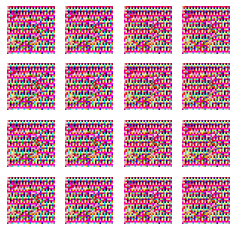

Training GAN at Time Step 1 of Epoch 7
Training GAN at Time Step 2 of Epoch 7
Training GAN at Time Step 3 of Epoch 7
Training GAN at Time Step 4 of Epoch 7
Training GAN at Time Step 5 of Epoch 7
Training GAN at Time Step 6 of Epoch 7
Training GAN at Time Step 7 of Epoch 7
Training GAN at Time Step 8 of Epoch 7
Training GAN at Time Step 9 of Epoch 7
Training GAN at Time Step 10 of Epoch 7
Training GAN at Time Step 11 of Epoch 7
Training GAN at Time Step 12 of Epoch 7
Training GAN at Time Step 13 of Epoch 7
Training GAN at Time Step 14 of Epoch 7
Training GAN at Time Step 15 of Epoch 7
Training GAN at Time Step 16 of Epoch 7
Training GAN at Time Step 17 of Epoch 7
Training GAN at Time Step 18 of Epoch 7
Training GAN at Time Step 19 of Epoch 7
Training GAN at Time Step 20 of Epoch 7
Training GAN at Time Step 21 of Epoch 7
Training GAN at Time Step 22 of Epoch 7
Training GAN at Time Step 23 of Epoch 7
Training GAN at Time Step 24 of Epoch 7
Training GAN at Time Step 25 of Epoch 7
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

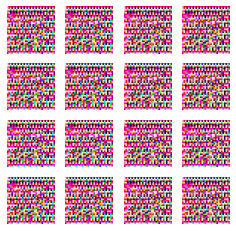

Training GAN at Time Step 1 of Epoch 8
Training GAN at Time Step 2 of Epoch 8
Training GAN at Time Step 3 of Epoch 8
Training GAN at Time Step 4 of Epoch 8
Training GAN at Time Step 5 of Epoch 8
Training GAN at Time Step 6 of Epoch 8
Training GAN at Time Step 7 of Epoch 8
Training GAN at Time Step 8 of Epoch 8
Training GAN at Time Step 9 of Epoch 8
Training GAN at Time Step 10 of Epoch 8
Training GAN at Time Step 11 of Epoch 8
Training GAN at Time Step 12 of Epoch 8
Training GAN at Time Step 13 of Epoch 8
Training GAN at Time Step 14 of Epoch 8
Training GAN at Time Step 15 of Epoch 8
Training GAN at Time Step 16 of Epoch 8
Training GAN at Time Step 17 of Epoch 8
Training GAN at Time Step 18 of Epoch 8
Training GAN at Time Step 19 of Epoch 8
Training GAN at Time Step 20 of Epoch 8
Training GAN at Time Step 21 of Epoch 8
Training GAN at Time Step 22 of Epoch 8
Training GAN at Time Step 23 of Epoch 8
Training GAN at Time Step 24 of Epoch 8
Training GAN at Time Step 25 of Epoch 8
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

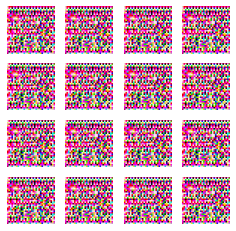

Training GAN at Time Step 1 of Epoch 9
Training GAN at Time Step 2 of Epoch 9
Training GAN at Time Step 3 of Epoch 9
Training GAN at Time Step 4 of Epoch 9
Training GAN at Time Step 5 of Epoch 9
Training GAN at Time Step 6 of Epoch 9
Training GAN at Time Step 7 of Epoch 9
Training GAN at Time Step 8 of Epoch 9
Training GAN at Time Step 9 of Epoch 9
Training GAN at Time Step 10 of Epoch 9
Training GAN at Time Step 11 of Epoch 9
Training GAN at Time Step 12 of Epoch 9
Training GAN at Time Step 13 of Epoch 9
Training GAN at Time Step 14 of Epoch 9
Training GAN at Time Step 15 of Epoch 9
Training GAN at Time Step 16 of Epoch 9
Training GAN at Time Step 17 of Epoch 9
Training GAN at Time Step 18 of Epoch 9
Training GAN at Time Step 19 of Epoch 9
Training GAN at Time Step 20 of Epoch 9
Training GAN at Time Step 21 of Epoch 9
Training GAN at Time Step 22 of Epoch 9
Training GAN at Time Step 23 of Epoch 9
Training GAN at Time Step 24 of Epoch 9
Training GAN at Time Step 25 of Epoch 9
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

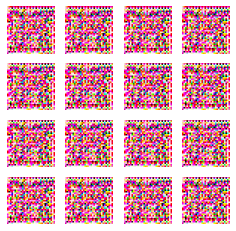

Training GAN at Time Step 1 of Epoch 10
Training GAN at Time Step 2 of Epoch 10
Training GAN at Time Step 3 of Epoch 10
Training GAN at Time Step 4 of Epoch 10
Training GAN at Time Step 5 of Epoch 10
Training GAN at Time Step 6 of Epoch 10
Training GAN at Time Step 7 of Epoch 10
Training GAN at Time Step 8 of Epoch 10
Training GAN at Time Step 9 of Epoch 10
Training GAN at Time Step 10 of Epoch 10
Training GAN at Time Step 11 of Epoch 10
Training GAN at Time Step 12 of Epoch 10
Training GAN at Time Step 13 of Epoch 10
Training GAN at Time Step 14 of Epoch 10
Training GAN at Time Step 15 of Epoch 10
Training GAN at Time Step 16 of Epoch 10
Training GAN at Time Step 17 of Epoch 10
Training GAN at Time Step 18 of Epoch 10
Training GAN at Time Step 19 of Epoch 10
Training GAN at Time Step 20 of Epoch 10
Training GAN at Time Step 21 of Epoch 10
Training GAN at Time Step 22 of Epoch 10
Training GAN at Time Step 23 of Epoch 10
Training GAN at Time Step 24 of Epoch 10
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

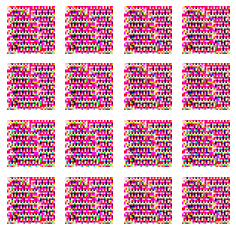

Training GAN at Time Step 1 of Epoch 11
Training GAN at Time Step 2 of Epoch 11
Training GAN at Time Step 3 of Epoch 11
Training GAN at Time Step 4 of Epoch 11
Training GAN at Time Step 5 of Epoch 11
Training GAN at Time Step 6 of Epoch 11
Training GAN at Time Step 7 of Epoch 11
Training GAN at Time Step 8 of Epoch 11
Training GAN at Time Step 9 of Epoch 11
Training GAN at Time Step 10 of Epoch 11
Training GAN at Time Step 11 of Epoch 11
Training GAN at Time Step 12 of Epoch 11
Training GAN at Time Step 13 of Epoch 11
Training GAN at Time Step 14 of Epoch 11
Training GAN at Time Step 15 of Epoch 11
Training GAN at Time Step 16 of Epoch 11
Training GAN at Time Step 17 of Epoch 11
Training GAN at Time Step 18 of Epoch 11
Training GAN at Time Step 19 of Epoch 11
Training GAN at Time Step 20 of Epoch 11
Training GAN at Time Step 21 of Epoch 11
Training GAN at Time Step 22 of Epoch 11
Training GAN at Time Step 23 of Epoch 11
Training GAN at Time Step 24 of Epoch 11
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

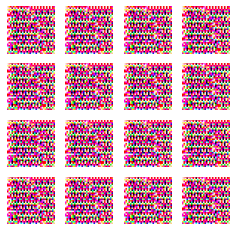

Training GAN at Time Step 1 of Epoch 12
Training GAN at Time Step 2 of Epoch 12
Training GAN at Time Step 3 of Epoch 12
Training GAN at Time Step 4 of Epoch 12
Training GAN at Time Step 5 of Epoch 12
Training GAN at Time Step 6 of Epoch 12
Training GAN at Time Step 7 of Epoch 12
Training GAN at Time Step 8 of Epoch 12
Training GAN at Time Step 9 of Epoch 12
Training GAN at Time Step 10 of Epoch 12
Training GAN at Time Step 11 of Epoch 12
Training GAN at Time Step 12 of Epoch 12
Training GAN at Time Step 13 of Epoch 12
Training GAN at Time Step 14 of Epoch 12
Training GAN at Time Step 15 of Epoch 12
Training GAN at Time Step 16 of Epoch 12
Training GAN at Time Step 17 of Epoch 12
Training GAN at Time Step 18 of Epoch 12
Training GAN at Time Step 19 of Epoch 12
Training GAN at Time Step 20 of Epoch 12
Training GAN at Time Step 21 of Epoch 12
Training GAN at Time Step 22 of Epoch 12
Training GAN at Time Step 23 of Epoch 12
Training GAN at Time Step 24 of Epoch 12
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

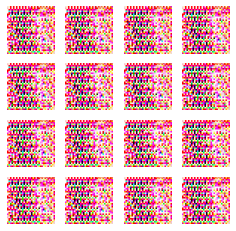

Training GAN at Time Step 1 of Epoch 13
Training GAN at Time Step 2 of Epoch 13
Training GAN at Time Step 3 of Epoch 13
Training GAN at Time Step 4 of Epoch 13
Training GAN at Time Step 5 of Epoch 13
Training GAN at Time Step 6 of Epoch 13
Training GAN at Time Step 7 of Epoch 13
Training GAN at Time Step 8 of Epoch 13
Training GAN at Time Step 9 of Epoch 13
Training GAN at Time Step 10 of Epoch 13
Training GAN at Time Step 11 of Epoch 13
Training GAN at Time Step 12 of Epoch 13
Training GAN at Time Step 13 of Epoch 13
Training GAN at Time Step 14 of Epoch 13
Training GAN at Time Step 15 of Epoch 13
Training GAN at Time Step 16 of Epoch 13
Training GAN at Time Step 17 of Epoch 13
Training GAN at Time Step 18 of Epoch 13
Training GAN at Time Step 19 of Epoch 13
Training GAN at Time Step 20 of Epoch 13
Training GAN at Time Step 21 of Epoch 13
Training GAN at Time Step 22 of Epoch 13
Training GAN at Time Step 23 of Epoch 13
Training GAN at Time Step 24 of Epoch 13
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

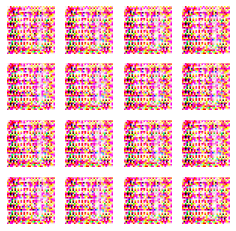

Training GAN at Time Step 1 of Epoch 14
Training GAN at Time Step 2 of Epoch 14
Training GAN at Time Step 3 of Epoch 14
Training GAN at Time Step 4 of Epoch 14
Training GAN at Time Step 5 of Epoch 14
Training GAN at Time Step 6 of Epoch 14
Training GAN at Time Step 7 of Epoch 14
Training GAN at Time Step 8 of Epoch 14
Training GAN at Time Step 9 of Epoch 14
Training GAN at Time Step 10 of Epoch 14
Training GAN at Time Step 11 of Epoch 14
Training GAN at Time Step 12 of Epoch 14
Training GAN at Time Step 13 of Epoch 14
Training GAN at Time Step 14 of Epoch 14
Training GAN at Time Step 15 of Epoch 14
Training GAN at Time Step 16 of Epoch 14
Training GAN at Time Step 17 of Epoch 14
Training GAN at Time Step 18 of Epoch 14
Training GAN at Time Step 19 of Epoch 14
Training GAN at Time Step 20 of Epoch 14
Training GAN at Time Step 21 of Epoch 14
Training GAN at Time Step 22 of Epoch 14
Training GAN at Time Step 23 of Epoch 14
Training GAN at Time Step 24 of Epoch 14
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

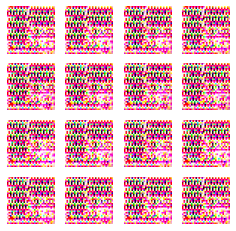

Training GAN at Time Step 1 of Epoch 15
Training GAN at Time Step 2 of Epoch 15
Training GAN at Time Step 3 of Epoch 15
Training GAN at Time Step 4 of Epoch 15
Training GAN at Time Step 5 of Epoch 15
Training GAN at Time Step 6 of Epoch 15
Training GAN at Time Step 7 of Epoch 15
Training GAN at Time Step 8 of Epoch 15
Training GAN at Time Step 9 of Epoch 15
Training GAN at Time Step 10 of Epoch 15
Training GAN at Time Step 11 of Epoch 15
Training GAN at Time Step 12 of Epoch 15
Training GAN at Time Step 13 of Epoch 15
Training GAN at Time Step 14 of Epoch 15
Training GAN at Time Step 15 of Epoch 15
Training GAN at Time Step 16 of Epoch 15
Training GAN at Time Step 17 of Epoch 15
Training GAN at Time Step 18 of Epoch 15
Training GAN at Time Step 19 of Epoch 15
Training GAN at Time Step 20 of Epoch 15
Training GAN at Time Step 21 of Epoch 15
Training GAN at Time Step 22 of Epoch 15
Training GAN at Time Step 23 of Epoch 15
Training GAN at Time Step 24 of Epoch 15
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

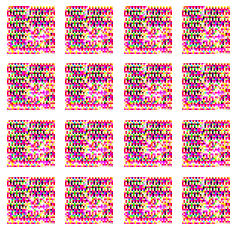

Training GAN at Time Step 1 of Epoch 16
Training GAN at Time Step 2 of Epoch 16
Training GAN at Time Step 3 of Epoch 16
Training GAN at Time Step 4 of Epoch 16
Training GAN at Time Step 5 of Epoch 16
Training GAN at Time Step 6 of Epoch 16
Training GAN at Time Step 7 of Epoch 16
Training GAN at Time Step 8 of Epoch 16
Training GAN at Time Step 9 of Epoch 16
Training GAN at Time Step 10 of Epoch 16
Training GAN at Time Step 11 of Epoch 16
Training GAN at Time Step 12 of Epoch 16
Training GAN at Time Step 13 of Epoch 16
Training GAN at Time Step 14 of Epoch 16
Training GAN at Time Step 15 of Epoch 16
Training GAN at Time Step 16 of Epoch 16
Training GAN at Time Step 17 of Epoch 16
Training GAN at Time Step 18 of Epoch 16
Training GAN at Time Step 19 of Epoch 16
Training GAN at Time Step 20 of Epoch 16
Training GAN at Time Step 21 of Epoch 16
Training GAN at Time Step 22 of Epoch 16
Training GAN at Time Step 23 of Epoch 16
Training GAN at Time Step 24 of Epoch 16
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

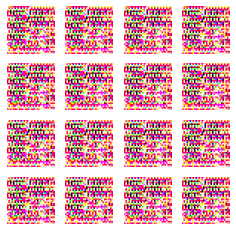

Training GAN at Time Step 1 of Epoch 17
Training GAN at Time Step 2 of Epoch 17
Training GAN at Time Step 3 of Epoch 17
Training GAN at Time Step 4 of Epoch 17
Training GAN at Time Step 5 of Epoch 17
Training GAN at Time Step 6 of Epoch 17
Training GAN at Time Step 7 of Epoch 17
Training GAN at Time Step 8 of Epoch 17
Training GAN at Time Step 9 of Epoch 17
Training GAN at Time Step 10 of Epoch 17
Training GAN at Time Step 11 of Epoch 17
Training GAN at Time Step 12 of Epoch 17
Training GAN at Time Step 13 of Epoch 17
Training GAN at Time Step 14 of Epoch 17
Training GAN at Time Step 15 of Epoch 17
Training GAN at Time Step 16 of Epoch 17
Training GAN at Time Step 17 of Epoch 17
Training GAN at Time Step 18 of Epoch 17
Training GAN at Time Step 19 of Epoch 17
Training GAN at Time Step 20 of Epoch 17
Training GAN at Time Step 21 of Epoch 17
Training GAN at Time Step 22 of Epoch 17
Training GAN at Time Step 23 of Epoch 17
Training GAN at Time Step 24 of Epoch 17
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

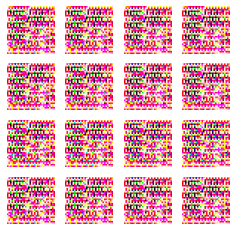

Training GAN at Time Step 1 of Epoch 18
Training GAN at Time Step 2 of Epoch 18
Training GAN at Time Step 3 of Epoch 18
Training GAN at Time Step 4 of Epoch 18
Training GAN at Time Step 5 of Epoch 18
Training GAN at Time Step 6 of Epoch 18
Training GAN at Time Step 7 of Epoch 18
Training GAN at Time Step 8 of Epoch 18
Training GAN at Time Step 9 of Epoch 18
Training GAN at Time Step 10 of Epoch 18
Training GAN at Time Step 11 of Epoch 18
Training GAN at Time Step 12 of Epoch 18
Training GAN at Time Step 13 of Epoch 18
Training GAN at Time Step 14 of Epoch 18
Training GAN at Time Step 15 of Epoch 18
Training GAN at Time Step 16 of Epoch 18
Training GAN at Time Step 17 of Epoch 18
Training GAN at Time Step 18 of Epoch 18
Training GAN at Time Step 19 of Epoch 18
Training GAN at Time Step 20 of Epoch 18
Training GAN at Time Step 21 of Epoch 18
Training GAN at Time Step 22 of Epoch 18
Training GAN at Time Step 23 of Epoch 18
Training GAN at Time Step 24 of Epoch 18
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

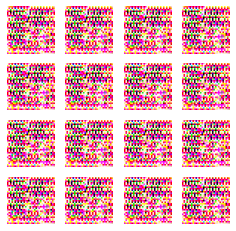

Training GAN at Time Step 1 of Epoch 19
Training GAN at Time Step 2 of Epoch 19
Training GAN at Time Step 3 of Epoch 19
Training GAN at Time Step 4 of Epoch 19
Training GAN at Time Step 5 of Epoch 19
Training GAN at Time Step 6 of Epoch 19
Training GAN at Time Step 7 of Epoch 19
Training GAN at Time Step 8 of Epoch 19
Training GAN at Time Step 9 of Epoch 19
Training GAN at Time Step 10 of Epoch 19
Training GAN at Time Step 11 of Epoch 19
Training GAN at Time Step 12 of Epoch 19
Training GAN at Time Step 13 of Epoch 19
Training GAN at Time Step 14 of Epoch 19
Training GAN at Time Step 15 of Epoch 19
Training GAN at Time Step 16 of Epoch 19
Training GAN at Time Step 17 of Epoch 19
Training GAN at Time Step 18 of Epoch 19
Training GAN at Time Step 19 of Epoch 19
Training GAN at Time Step 20 of Epoch 19
Training GAN at Time Step 21 of Epoch 19
Training GAN at Time Step 22 of Epoch 19
Training GAN at Time Step 23 of Epoch 19
Training GAN at Time Step 24 of Epoch 19
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

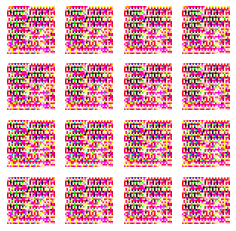

Training GAN at Time Step 1 of Epoch 20
Training GAN at Time Step 2 of Epoch 20
Training GAN at Time Step 3 of Epoch 20
Training GAN at Time Step 4 of Epoch 20
Training GAN at Time Step 5 of Epoch 20
Training GAN at Time Step 6 of Epoch 20
Training GAN at Time Step 7 of Epoch 20
Training GAN at Time Step 8 of Epoch 20
Training GAN at Time Step 9 of Epoch 20
Training GAN at Time Step 10 of Epoch 20
Training GAN at Time Step 11 of Epoch 20
Training GAN at Time Step 12 of Epoch 20
Training GAN at Time Step 13 of Epoch 20
Training GAN at Time Step 14 of Epoch 20
Training GAN at Time Step 15 of Epoch 20
Training GAN at Time Step 16 of Epoch 20
Training GAN at Time Step 17 of Epoch 20
Training GAN at Time Step 18 of Epoch 20
Training GAN at Time Step 19 of Epoch 20
Training GAN at Time Step 20 of Epoch 20
Training GAN at Time Step 21 of Epoch 20
Training GAN at Time Step 22 of Epoch 20
Training GAN at Time Step 23 of Epoch 20
Training GAN at Time Step 24 of Epoch 20
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

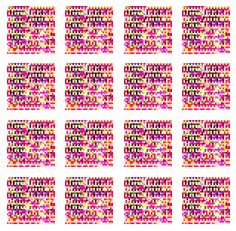

Training GAN at Time Step 1 of Epoch 21
Training GAN at Time Step 2 of Epoch 21
Training GAN at Time Step 3 of Epoch 21
Training GAN at Time Step 4 of Epoch 21
Training GAN at Time Step 5 of Epoch 21
Training GAN at Time Step 6 of Epoch 21
Training GAN at Time Step 7 of Epoch 21
Training GAN at Time Step 8 of Epoch 21
Training GAN at Time Step 9 of Epoch 21
Training GAN at Time Step 10 of Epoch 21
Training GAN at Time Step 11 of Epoch 21
Training GAN at Time Step 12 of Epoch 21
Training GAN at Time Step 13 of Epoch 21
Training GAN at Time Step 14 of Epoch 21
Training GAN at Time Step 15 of Epoch 21
Training GAN at Time Step 16 of Epoch 21
Training GAN at Time Step 17 of Epoch 21
Training GAN at Time Step 18 of Epoch 21
Training GAN at Time Step 19 of Epoch 21
Training GAN at Time Step 20 of Epoch 21
Training GAN at Time Step 21 of Epoch 21
Training GAN at Time Step 22 of Epoch 21
Training GAN at Time Step 23 of Epoch 21
Training GAN at Time Step 24 of Epoch 21
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

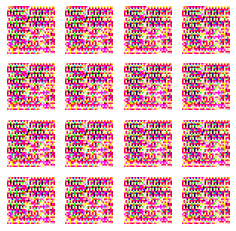

Training GAN at Time Step 1 of Epoch 22
Training GAN at Time Step 2 of Epoch 22
Training GAN at Time Step 3 of Epoch 22
Training GAN at Time Step 4 of Epoch 22
Training GAN at Time Step 5 of Epoch 22
Training GAN at Time Step 6 of Epoch 22
Training GAN at Time Step 7 of Epoch 22
Training GAN at Time Step 8 of Epoch 22
Training GAN at Time Step 9 of Epoch 22
Training GAN at Time Step 10 of Epoch 22
Training GAN at Time Step 11 of Epoch 22
Training GAN at Time Step 12 of Epoch 22
Training GAN at Time Step 13 of Epoch 22
Training GAN at Time Step 14 of Epoch 22
Training GAN at Time Step 15 of Epoch 22
Training GAN at Time Step 16 of Epoch 22
Training GAN at Time Step 17 of Epoch 22
Training GAN at Time Step 18 of Epoch 22
Training GAN at Time Step 19 of Epoch 22
Training GAN at Time Step 20 of Epoch 22
Training GAN at Time Step 21 of Epoch 22
Training GAN at Time Step 22 of Epoch 22
Training GAN at Time Step 23 of Epoch 22
Training GAN at Time Step 24 of Epoch 22
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

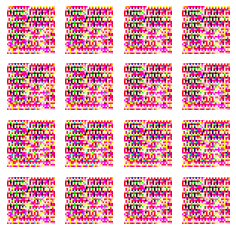

Training GAN at Time Step 1 of Epoch 23
Training GAN at Time Step 2 of Epoch 23
Training GAN at Time Step 3 of Epoch 23
Training GAN at Time Step 4 of Epoch 23
Training GAN at Time Step 5 of Epoch 23
Training GAN at Time Step 6 of Epoch 23
Training GAN at Time Step 7 of Epoch 23
Training GAN at Time Step 8 of Epoch 23
Training GAN at Time Step 9 of Epoch 23
Training GAN at Time Step 10 of Epoch 23
Training GAN at Time Step 11 of Epoch 23
Training GAN at Time Step 12 of Epoch 23
Training GAN at Time Step 13 of Epoch 23
Training GAN at Time Step 14 of Epoch 23
Training GAN at Time Step 15 of Epoch 23
Training GAN at Time Step 16 of Epoch 23
Training GAN at Time Step 17 of Epoch 23
Training GAN at Time Step 18 of Epoch 23
Training GAN at Time Step 19 of Epoch 23
Training GAN at Time Step 20 of Epoch 23
Training GAN at Time Step 21 of Epoch 23
Training GAN at Time Step 22 of Epoch 23
Training GAN at Time Step 23 of Epoch 23
Training GAN at Time Step 24 of Epoch 23
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

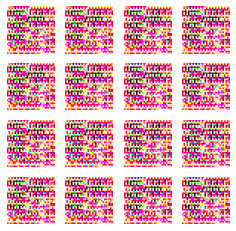

Training GAN at Time Step 1 of Epoch 24
Training GAN at Time Step 2 of Epoch 24
Training GAN at Time Step 3 of Epoch 24
Training GAN at Time Step 4 of Epoch 24
Training GAN at Time Step 5 of Epoch 24
Training GAN at Time Step 6 of Epoch 24
Training GAN at Time Step 7 of Epoch 24
Training GAN at Time Step 8 of Epoch 24
Training GAN at Time Step 9 of Epoch 24
Training GAN at Time Step 10 of Epoch 24
Training GAN at Time Step 11 of Epoch 24
Training GAN at Time Step 12 of Epoch 24
Training GAN at Time Step 13 of Epoch 24
Training GAN at Time Step 14 of Epoch 24
Training GAN at Time Step 15 of Epoch 24
Training GAN at Time Step 16 of Epoch 24
Training GAN at Time Step 17 of Epoch 24
Training GAN at Time Step 18 of Epoch 24
Training GAN at Time Step 19 of Epoch 24
Training GAN at Time Step 20 of Epoch 24
Training GAN at Time Step 21 of Epoch 24
Training GAN at Time Step 22 of Epoch 24
Training GAN at Time Step 23 of Epoch 24
Training GAN at Time Step 24 of Epoch 24
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

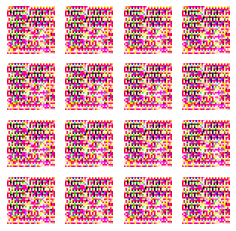

Training GAN at Time Step 1 of Epoch 25
Training GAN at Time Step 2 of Epoch 25
Training GAN at Time Step 3 of Epoch 25
Training GAN at Time Step 4 of Epoch 25
Training GAN at Time Step 5 of Epoch 25
Training GAN at Time Step 6 of Epoch 25
Training GAN at Time Step 7 of Epoch 25
Training GAN at Time Step 8 of Epoch 25
Training GAN at Time Step 9 of Epoch 25
Training GAN at Time Step 10 of Epoch 25
Training GAN at Time Step 11 of Epoch 25
Training GAN at Time Step 12 of Epoch 25
Training GAN at Time Step 13 of Epoch 25
Training GAN at Time Step 14 of Epoch 25
Training GAN at Time Step 15 of Epoch 25
Training GAN at Time Step 16 of Epoch 25
Training GAN at Time Step 17 of Epoch 25
Training GAN at Time Step 18 of Epoch 25
Training GAN at Time Step 19 of Epoch 25
Training GAN at Time Step 20 of Epoch 25
Training GAN at Time Step 21 of Epoch 25
Training GAN at Time Step 22 of Epoch 25
Training GAN at Time Step 23 of Epoch 25
Training GAN at Time Step 24 of Epoch 25
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

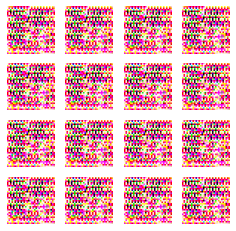

Training GAN at Time Step 1 of Epoch 26
Training GAN at Time Step 2 of Epoch 26
Training GAN at Time Step 3 of Epoch 26
Training GAN at Time Step 4 of Epoch 26
Training GAN at Time Step 5 of Epoch 26
Training GAN at Time Step 6 of Epoch 26
Training GAN at Time Step 7 of Epoch 26
Training GAN at Time Step 8 of Epoch 26
Training GAN at Time Step 9 of Epoch 26
Training GAN at Time Step 10 of Epoch 26
Training GAN at Time Step 11 of Epoch 26
Training GAN at Time Step 12 of Epoch 26
Training GAN at Time Step 13 of Epoch 26
Training GAN at Time Step 14 of Epoch 26
Training GAN at Time Step 15 of Epoch 26
Training GAN at Time Step 16 of Epoch 26
Training GAN at Time Step 17 of Epoch 26
Training GAN at Time Step 18 of Epoch 26
Training GAN at Time Step 19 of Epoch 26
Training GAN at Time Step 20 of Epoch 26
Training GAN at Time Step 21 of Epoch 26
Training GAN at Time Step 22 of Epoch 26
Training GAN at Time Step 23 of Epoch 26
Training GAN at Time Step 24 of Epoch 26
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

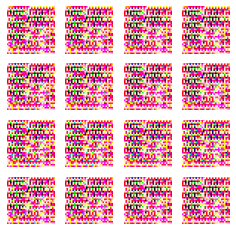

Training GAN at Time Step 1 of Epoch 27
Training GAN at Time Step 2 of Epoch 27
Training GAN at Time Step 3 of Epoch 27
Training GAN at Time Step 4 of Epoch 27
Training GAN at Time Step 5 of Epoch 27
Training GAN at Time Step 6 of Epoch 27
Training GAN at Time Step 7 of Epoch 27
Training GAN at Time Step 8 of Epoch 27
Training GAN at Time Step 9 of Epoch 27
Training GAN at Time Step 10 of Epoch 27
Training GAN at Time Step 11 of Epoch 27
Training GAN at Time Step 12 of Epoch 27
Training GAN at Time Step 13 of Epoch 27
Training GAN at Time Step 14 of Epoch 27
Training GAN at Time Step 15 of Epoch 27
Training GAN at Time Step 16 of Epoch 27
Training GAN at Time Step 17 of Epoch 27
Training GAN at Time Step 18 of Epoch 27
Training GAN at Time Step 19 of Epoch 27
Training GAN at Time Step 20 of Epoch 27
Training GAN at Time Step 21 of Epoch 27
Training GAN at Time Step 22 of Epoch 27
Training GAN at Time Step 23 of Epoch 27
Training GAN at Time Step 24 of Epoch 27
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

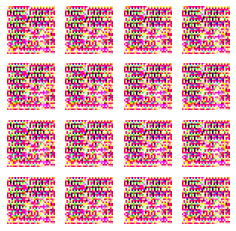

Training GAN at Time Step 1 of Epoch 28
Training GAN at Time Step 2 of Epoch 28
Training GAN at Time Step 3 of Epoch 28
Training GAN at Time Step 4 of Epoch 28
Training GAN at Time Step 5 of Epoch 28
Training GAN at Time Step 6 of Epoch 28
Training GAN at Time Step 7 of Epoch 28
Training GAN at Time Step 8 of Epoch 28
Training GAN at Time Step 9 of Epoch 28
Training GAN at Time Step 10 of Epoch 28
Training GAN at Time Step 11 of Epoch 28
Training GAN at Time Step 12 of Epoch 28
Training GAN at Time Step 13 of Epoch 28
Training GAN at Time Step 14 of Epoch 28
Training GAN at Time Step 15 of Epoch 28
Training GAN at Time Step 16 of Epoch 28
Training GAN at Time Step 17 of Epoch 28
Training GAN at Time Step 18 of Epoch 28
Training GAN at Time Step 19 of Epoch 28
Training GAN at Time Step 20 of Epoch 28
Training GAN at Time Step 21 of Epoch 28
Training GAN at Time Step 22 of Epoch 28
Training GAN at Time Step 23 of Epoch 28
Training GAN at Time Step 24 of Epoch 28
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

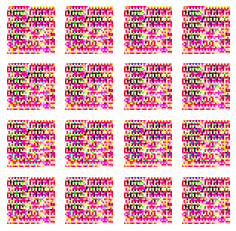

Training GAN at Time Step 1 of Epoch 29
Training GAN at Time Step 2 of Epoch 29
Training GAN at Time Step 3 of Epoch 29
Training GAN at Time Step 4 of Epoch 29
Training GAN at Time Step 5 of Epoch 29
Training GAN at Time Step 6 of Epoch 29
Training GAN at Time Step 7 of Epoch 29
Training GAN at Time Step 8 of Epoch 29
Training GAN at Time Step 9 of Epoch 29
Training GAN at Time Step 10 of Epoch 29
Training GAN at Time Step 11 of Epoch 29
Training GAN at Time Step 12 of Epoch 29
Training GAN at Time Step 13 of Epoch 29
Training GAN at Time Step 14 of Epoch 29
Training GAN at Time Step 15 of Epoch 29
Training GAN at Time Step 16 of Epoch 29
Training GAN at Time Step 17 of Epoch 29
Training GAN at Time Step 18 of Epoch 29
Training GAN at Time Step 19 of Epoch 29
Training GAN at Time Step 20 of Epoch 29
Training GAN at Time Step 21 of Epoch 29
Training GAN at Time Step 22 of Epoch 29
Training GAN at Time Step 23 of Epoch 29
Training GAN at Time Step 24 of Epoch 29
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

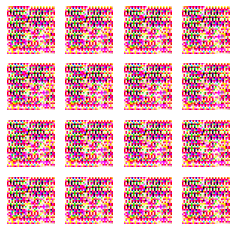

Training GAN at Time Step 1 of Epoch 30
Training GAN at Time Step 2 of Epoch 30
Training GAN at Time Step 3 of Epoch 30
Training GAN at Time Step 4 of Epoch 30
Training GAN at Time Step 5 of Epoch 30
Training GAN at Time Step 6 of Epoch 30
Training GAN at Time Step 7 of Epoch 30
Training GAN at Time Step 8 of Epoch 30
Training GAN at Time Step 9 of Epoch 30
Training GAN at Time Step 10 of Epoch 30
Training GAN at Time Step 11 of Epoch 30
Training GAN at Time Step 12 of Epoch 30
Training GAN at Time Step 13 of Epoch 30
Training GAN at Time Step 14 of Epoch 30
Training GAN at Time Step 15 of Epoch 30
Training GAN at Time Step 16 of Epoch 30
Training GAN at Time Step 17 of Epoch 30


KeyboardInterrupt: ignored

In [ ]:
train_gan(real_imgs_datagen=unlabeled_datagen,total_epochs=GAN_epochs)

In [ ]:
latest_checkpoint_path = tf.train.latest_checkpoint("/content/drive/MyDrive/GAN_training_checkpoints")

In [ ]:
latest_checkpoint_path

'/content/drive/MyDrive/GAN_training_checkpoints/ckpt-3'

In [ ]:
GAN_checkpoint.restore(latest_checkpoint_path)

In [ ]:
def generate_and_save_images(generator_model,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

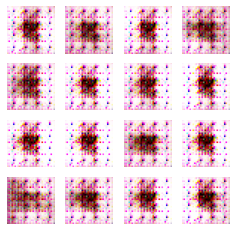

In [ ]:
generate_and_save_images(generator_model=G,test_input=constant_noise)

In [ ]:
unlbld_imgs_base_path = "/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/unlabeled"

In [ ]:
from random import randint

In [ ]:
imgs_names_list = os.listdir(unlbld_imgs_base_path)

In [ ]:
total_imgs = len(imgs_names_list)

In [ ]:
single_img = plt.imread(os.path.join(unlbld_imgs_base_path,imgs_names_list[randint(0,total_imgs-1)]))

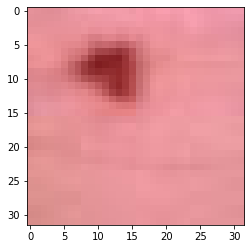

In [ ]:
plt.imshow(single_img)

In [ ]:
single_fake_img = G(tf.random.normal(shape=(1,100)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


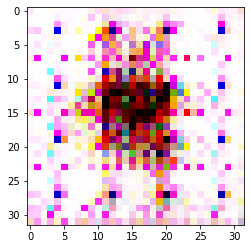

In [ ]:
plt.imshow(single_fake_img[0,:,:,:])

In [ ]:
def discriminator_base():

  input_to_cls = Input(shape=(32,32,3))

  disc_base = Sequential(name="disc_base")
  disc_base.add(input_to_cls)

  for layer in D.layers[0:10]:
    disc_base.add(layer)

  return disc_base

In [ ]:
def unsupervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [ ]:
def supervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [ ]:
unsupervised_cls = unsupervised_classifier()
supervised_cls = supervised_classifier()

In [ ]:
unsupervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)
supervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)

In [ ]:
supervised_cls_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_cv_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [ ]:
def unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = tf.ones_like(real_imgs_preds)
  fake_imgs_labels = tf.zeros_like(fake_imgs_preds)

  real_imgs_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_loss + fake_imgs_loss

  return total_loss

In [ ]:
def supervised_cls_loss(imgs_labels,imgs_preds):

  return bce_loss(y_true=imgs_labels,y_pred=imgs_preds)

In [ ]:
@tf.function
def ssl_training_step(labeled_images,unlabeled_images):

  G.trainable = False
  unsupervised_cls.trainable = True
  supervised_cls.trainable = True

  with tf.GradientTape() as supervised_cls_tape, tf.GradientTape() as unsupervised_cls_tape, tf.GradientTape() as gen_tape:

    labeled_imgs_preds = supervised_cls(labeled_images[0],training=True)
    
    supervised_loss = supervised_cls_loss(imgs_labels=labeled_images[1],imgs_preds=labeled_imgs_preds)

    gradients_of_supervised_cls = supervised_cls_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
    supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised_cls,supervised_cls.trainable_variables))

    noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_images = G(noise,training=False)

    real_imgs_preds = unsupervised_cls(unlabeled_images,training=True)
    fake_imgs_preds = unsupervised_cls(generated_images,training=True)

    unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_unsupervised_cls = unsupervised_cls_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
    unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised_cls,unsupervised_cls.trainable_variables))

    supervised_cls.trainable = False
    unsupervised_cls.trainable = False

  return supervised_loss,labeled_imgs_preds

In [ ]:
cls_checkpoint_dir = "/content/drive/MyDrive/cls_training_checkpoints"
checkpoint_prefix = os.path.join(cls_checkpoint_dir,"ckpt")
cls_checkpoint = tf.train.Checkpoint(optimizer=[supervised_cls_optimizer,unsupervised_cls_optimizer],
                                     model=[supervised_cls,unsupervised_cls])

In [ ]:
cls_epochs = 15

In [ ]:
cv_data_gen = ImageDataGenerator()

In [ ]:
cv_datagen = cv_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/cv",
                                             target_size=(32,32),
                                             classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/cv"),
                                             class_mode="binary",batch_size=150)

Found 300 images belonging to 2 classes.


In [ ]:
labeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)

In [ ]:
labeled_datagen = labeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/labeled",
                                                       target_size=(32,32),
                                                       classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/labeled"),
                                                       class_mode="binary",batch_size=7)

Found 200 images belonging to 2 classes.


In [ ]:
def train_ssl_classifier(labeled_imgs_datagen,unlabeled_imgs_datagen,cv_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for labeled_images_batch, unlabeled_images_batch in zip(labeled_imgs_datagen,unlabeled_imgs_datagen):

      supervised_loss, labeled_imgs_preds = ssl_training_step(labeled_images=labeled_images_batch,unlabeled_images=unlabeled_images_batch[0])

      if time_step > len(os.listdir("/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/unlabeled"))//batch_size:
        break

      supervised_cls_train_acc_metric.update_state(labeled_images_batch[1],labeled_imgs_preds)
      print("Training Loss at Time Step {} of Epoch {} is {}".format(time_step,epoch+1,float(supervised_loss)))

      time_step = time_step + 1

    training_accuracy = supervised_cls_train_acc_metric.result()
    print("\nTraining Accuracy after Epoch {} is {}".format(epoch+1,float(training_accuracy)))

    supervised_cls_train_acc_metric.reset_states()

    cv_time_steps = 0

    for X_cv,Y_cv_labels in cv_imgs_datagen:

      if cv_time_steps > 300//150:
        break

      cv_time_steps = cv_time_steps + 1

      Y_cv_preds = supervised_cls(X_cv,training=False)
      supervised_cls_cv_acc_metric.update_state(Y_cv_labels,Y_cv_preds)

    cv_accuracy = supervised_cls_cv_acc_metric.result()
    print("Corss Validation Accuracy after Epoch {} is {}\n".format(epoch+1,float(cv_accuracy)))

    supervised_cls_cv_acc_metric.reset_states()

    cls_checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
train_ssl_classifier(labeled_imgs_datagen=labeled_datagen,unlabeled_imgs_datagen=unlabeled_datagen,
                     cv_imgs_datagen=cv_datagen,total_epochs=cls_epochs)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


Training Loss at Time Step 1 of Epoch 1 is 0.7174123525619507
Training Loss at Time Step 2 of Epoch 1 is 0.6902880072593689
Training Loss at Time Step 3 of Epoch 1 is 0.6898727416992188
Training Loss at Time Step 4 of Epoch 1 is 0.6863121390342712
Training Loss at Time Step 5 of Epoch 1 is 0.6968927979469299
Training Loss at Time Step 6 of Epoch 1 is 0.6754986047744751
Training Loss at Time Step 7 of Epoch 1 is 0.7286058068275452
Training Loss at Time Step 8 of Epoch 1 is 0.6922131776809692
Training Loss at Time Step 9 of Epoch 1 is 0.7097687125205994
Training Loss at Time Step 10 of Epoch 1 is 0.7027522325515747
Training Loss at Time Step 11 of Epoch 1 is 0.6934250593185425
Training Loss at Time Step 12 of Epoch 1 is 0.6937993764877319
Training Loss at Time Step 13 of Epoch 1 is 0.6938223242759705
Training Loss at Time Step 14 of Epoch 1 is 0.6929575800895691
Training Loss at Time Step 15 of Epoch 1 is 0.6942033767700195
Training Loss at Time Step 16 of Epoch 1 is 0.6930352449417114
T